In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [7]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    row, col = 64, 64
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

In [8]:
data = []
imgs_path = "data"

kernel = np.ones((2,2),np.uint8)

for filename in os.listdir(imgs_path):
            f = os.path.join(imgs_path, filename)
            data.append(cv2.threshold(cv2.dilate(cv2.imread(f, 0), kernel), 20, 255, cv2.THRESH_BINARY)[1])

random.shuffle(data)

xtrain = data[:14000]
xtest = data[14000:]

noises = ["gaussian", "speckle"]
mean = 0
var = 10000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0
traindata = np.zeros((14000, 64, 64))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((956, 64, 64))

for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 14000/14000 [00:01<00:00, 13154.46it/s]



gaussian noise addition completed to images


100%|██████████| 956/956 [00:00<00:00, 13166.64it/s]


gaussian noise addition completed to images


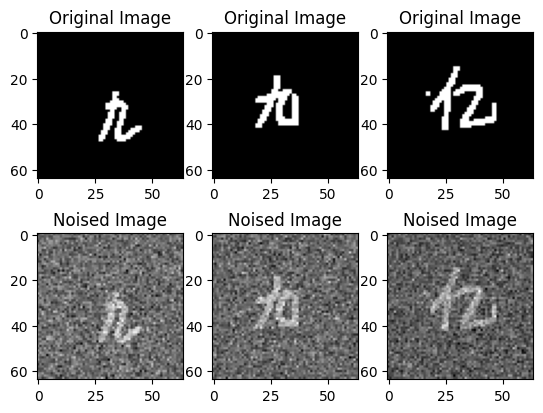

SNR:  0.27128959729927793
PSNR:  18.729576392768415


In [9]:
f, axes = plt.subplots(2, 3)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with gaussian noise
axes[0, 1].imshow(xtrain[5000], cmap="gray")
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[5000], cmap='gray')
axes[1, 1].set_title("Noised Image")

# showing images with speckle noise
axes[0, 2].imshow(xtrain[10000], cmap='gray')
axes[0, 2].set_title("Original Image")
axes[1, 2].imshow(traindata[10000], cmap="gray")
axes[1, 2].set_title("Noised Image")
plt.show()

snr_estim = 0
psnr_estim = 0

for i in range(1000):
    snr_estim += snr(xtrain[i], traindata[i])
    psnr_estim += psnr(xtrain[i], traindata[i])

print("SNR: ", snr_estim/1000)
print("PSNR: ", psnr_estim/1000)

In [10]:
class noisedDataset(Dataset):
    def __init__(self, datasetnoised, datasetclean, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]

        if self.transform is not None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return xNoise, xClean

In [11]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

trainset = noisedDataset(traindata, xtrain, tsfms)
testset = noisedDataset(testdata, xtest, tsfms)

batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

In [12]:
from torch import nn

class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model, self).__init__()
        self.encoderDense = nn.Sequential(
            nn.Linear(32 * 32, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )

        self.decoderDense = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 32 * 32),
            nn.Sigmoid(),
        )

        self.encoderConv1D = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv1D = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        self.encoderConv2D = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv2D = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoderConv1D(x)
        x = self.decoderConv1D(x)

        return x

In [13]:
from torchsummary import summary

model = denoising_model()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

summary(model, (1, 32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 1024]             512
              ReLU-2            [-1, 128, 1024]               0
         MaxPool1d-3             [-1, 128, 512]               0
            Conv1d-4              [-1, 64, 512]          24,640
              ReLU-5              [-1, 64, 512]               0
         MaxPool1d-6              [-1, 64, 256]               0
            Conv1d-7              [-1, 32, 256]           6,176
              ReLU-8              [-1, 32, 256]               0
         MaxPool1d-9              [-1, 32, 128]               0
           Conv1d-10              [-1, 16, 128]           1,552
             ReLU-11              [-1, 16, 128]               0
  ConvTranspose1d-12              [-1, 32, 256]           1,568
             ReLU-13              [-1, 32, 256]               0
  ConvTranspose1d-14              [-1, 

In [14]:
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

print(device)

model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 50
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda:0


In [15]:
image_test = []
for dirty, clean in testloader:
    image_test = dirty
    image_test_clean = clean

image_test = image_test.view(1, 1, 32*32).type(torch.FloatTensor)

image_test = image_test.to(device)

In [16]:
%matplotlib qt

image_test2 = image_test.view(1, 32, 32)
image_test2 = image_test2.permute(1, 2, 0).squeeze(2)
image_test2 = image_test2.detach().cpu().numpy()

image_test_clean = image_test_clean.view(1, 32, 32)
image_test2_clean = image_test_clean.permute(1, 2, 0).squeeze(2)
image_test2_clean = image_test2_clean.detach().cpu().numpy()

# plt.clf()
# plt.imshow(image_test2)
# plt.show()
plt.imshow(image_test2_clean)
plt.show()


In [17]:
%matplotlib qt

for epoch in range(epochs):

    print("Entering Epoch: ", epoch)
    for dirty, clean in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), 1, 32*32).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), 1, 32*32).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))

    image_res = model(image_test)

    image_res = image_res.view(1, 32, 32)
    image_res = image_res.permute(1, 2, 0).squeeze(2)
    image_res = image_res.detach().cpu().numpy()

    plt.clf()
    plt.imshow(image_res)
    plt.colorbar()

    plt.savefig(f"animation/1_{epoch}.png")
    plt.pause(0.01)

%matplotlib inline

Entering Epoch:  0


100%|██████████| 438/438 [00:05<00:00, 77.60it/s]


======> epoch: 0/50, Loss:0.02933170273900032
Entering Epoch:  1


100%|██████████| 438/438 [00:05<00:00, 82.55it/s]


======> epoch: 1/50, Loss:0.019040346145629883
Entering Epoch:  2


100%|██████████| 438/438 [00:05<00:00, 83.44it/s]


======> epoch: 2/50, Loss:0.017526209354400635
Entering Epoch:  3


100%|██████████| 438/438 [00:05<00:00, 84.52it/s]


======> epoch: 3/50, Loss:0.016229916363954544
Entering Epoch:  4


100%|██████████| 438/438 [00:05<00:00, 86.57it/s]


======> epoch: 4/50, Loss:0.01456989161670208
Entering Epoch:  5


100%|██████████| 438/438 [00:05<00:00, 84.51it/s]


======> epoch: 5/50, Loss:0.013348734006285667
Entering Epoch:  6


100%|██████████| 438/438 [00:05<00:00, 87.19it/s]


======> epoch: 6/50, Loss:0.013296771794557571
Entering Epoch:  7


100%|██████████| 438/438 [00:05<00:00, 85.27it/s]


======> epoch: 7/50, Loss:0.011517442762851715
Entering Epoch:  8


100%|██████████| 438/438 [00:05<00:00, 87.38it/s]


======> epoch: 8/50, Loss:0.014766514301300049
Entering Epoch:  9


100%|██████████| 438/438 [00:05<00:00, 84.58it/s]


======> epoch: 9/50, Loss:0.010085300542414188
Entering Epoch:  10


100%|██████████| 438/438 [00:05<00:00, 85.50it/s]


======> epoch: 10/50, Loss:0.00901638064533472
Entering Epoch:  11


100%|██████████| 438/438 [00:05<00:00, 84.36it/s]


======> epoch: 11/50, Loss:0.007672057021409273
Entering Epoch:  12


100%|██████████| 438/438 [00:05<00:00, 85.15it/s]


======> epoch: 12/50, Loss:0.006408313289284706
Entering Epoch:  13


100%|██████████| 438/438 [00:05<00:00, 84.87it/s]


======> epoch: 13/50, Loss:0.009722551330924034
Entering Epoch:  14


100%|██████████| 438/438 [00:05<00:00, 83.90it/s]


======> epoch: 14/50, Loss:0.007380593102425337
Entering Epoch:  15


100%|██████████| 438/438 [00:05<00:00, 85.50it/s]


======> epoch: 15/50, Loss:0.010319214314222336
Entering Epoch:  16


100%|██████████| 438/438 [00:05<00:00, 81.67it/s]


======> epoch: 16/50, Loss:0.007828214205801487
Entering Epoch:  17


100%|██████████| 438/438 [00:05<00:00, 85.33it/s]


======> epoch: 17/50, Loss:0.00755565520375967
Entering Epoch:  18


100%|██████████| 438/438 [00:05<00:00, 83.35it/s]


======> epoch: 18/50, Loss:0.00851781852543354
Entering Epoch:  19


100%|██████████| 438/438 [00:05<00:00, 84.28it/s]


======> epoch: 19/50, Loss:0.009046723134815693
Entering Epoch:  20


100%|██████████| 438/438 [00:05<00:00, 82.59it/s]


======> epoch: 20/50, Loss:0.008995382115244865
Entering Epoch:  21


100%|██████████| 438/438 [00:05<00:00, 84.89it/s]


======> epoch: 21/50, Loss:0.0065903207287192345
Entering Epoch:  22


100%|██████████| 438/438 [00:05<00:00, 81.96it/s]


======> epoch: 22/50, Loss:0.008742159232497215
Entering Epoch:  23


100%|██████████| 438/438 [00:05<00:00, 84.18it/s]


======> epoch: 23/50, Loss:0.007108266931027174
Entering Epoch:  24


100%|██████████| 438/438 [00:05<00:00, 82.88it/s]


======> epoch: 24/50, Loss:0.008310242556035519
Entering Epoch:  25


100%|██████████| 438/438 [00:05<00:00, 84.33it/s]


======> epoch: 25/50, Loss:0.006165643222630024
Entering Epoch:  26


100%|██████████| 438/438 [00:05<00:00, 83.89it/s]


======> epoch: 26/50, Loss:0.006071787793189287
Entering Epoch:  27


100%|██████████| 438/438 [00:05<00:00, 82.50it/s]


======> epoch: 27/50, Loss:0.006563227158039808
Entering Epoch:  28


100%|██████████| 438/438 [00:05<00:00, 82.31it/s]


======> epoch: 28/50, Loss:0.0064603956416249275
Entering Epoch:  29


100%|██████████| 438/438 [00:05<00:00, 82.55it/s]


======> epoch: 29/50, Loss:0.00662080105394125
Entering Epoch:  30


100%|██████████| 438/438 [00:05<00:00, 84.83it/s]


======> epoch: 30/50, Loss:0.00539625808596611
Entering Epoch:  31


100%|██████████| 438/438 [00:05<00:00, 80.78it/s]


======> epoch: 31/50, Loss:0.007444214075803757
Entering Epoch:  32


100%|██████████| 438/438 [00:05<00:00, 83.66it/s]


======> epoch: 32/50, Loss:0.007435346953570843
Entering Epoch:  33


100%|██████████| 438/438 [00:05<00:00, 81.07it/s]


======> epoch: 33/50, Loss:0.006133429706096649
Entering Epoch:  34


100%|██████████| 438/438 [00:05<00:00, 84.03it/s]


======> epoch: 34/50, Loss:0.006953313946723938
Entering Epoch:  35


100%|██████████| 438/438 [00:05<00:00, 81.36it/s]


======> epoch: 35/50, Loss:0.006539051420986652
Entering Epoch:  36


100%|██████████| 438/438 [00:05<00:00, 83.40it/s]


======> epoch: 36/50, Loss:0.0072156209498643875
Entering Epoch:  37


100%|██████████| 438/438 [00:05<00:00, 80.58it/s]


======> epoch: 37/50, Loss:0.006170137785375118
Entering Epoch:  38


100%|██████████| 438/438 [00:05<00:00, 83.69it/s]


======> epoch: 38/50, Loss:0.005603281781077385
Entering Epoch:  39


100%|██████████| 438/438 [00:05<00:00, 81.51it/s]


======> epoch: 39/50, Loss:0.0056115081533789635
Entering Epoch:  40


100%|██████████| 438/438 [00:05<00:00, 84.11it/s]


======> epoch: 40/50, Loss:0.005393785424530506
Entering Epoch:  41


100%|██████████| 438/438 [00:05<00:00, 83.94it/s]


======> epoch: 41/50, Loss:0.0055243270471692085
Entering Epoch:  42


100%|██████████| 438/438 [00:05<00:00, 80.68it/s]


======> epoch: 42/50, Loss:0.004849283955991268
Entering Epoch:  43


100%|██████████| 438/438 [00:05<00:00, 82.75it/s]


======> epoch: 43/50, Loss:0.005310128442943096
Entering Epoch:  44


100%|██████████| 438/438 [00:05<00:00, 81.77it/s]


======> epoch: 44/50, Loss:0.0062871696427464485
Entering Epoch:  45


100%|██████████| 438/438 [00:05<00:00, 82.08it/s]


======> epoch: 45/50, Loss:0.006682636681944132
Entering Epoch:  46


100%|██████████| 438/438 [00:05<00:00, 83.18it/s]


======> epoch: 46/50, Loss:0.004165941849350929
Entering Epoch:  47


100%|██████████| 438/438 [00:05<00:00, 84.34it/s]


======> epoch: 47/50, Loss:0.005227492190897465
Entering Epoch:  48


100%|██████████| 438/438 [00:05<00:00, 81.88it/s]


======> epoch: 48/50, Loss:0.0047715771943330765
Entering Epoch:  49


100%|██████████| 438/438 [00:05<00:00, 85.07it/s]


======> epoch: 49/50, Loss:0.005453204270452261


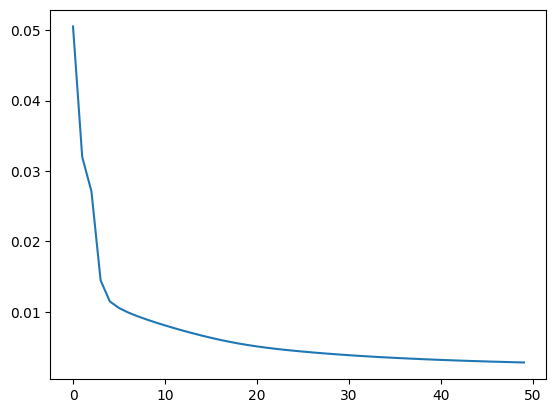

In [328]:
plt.plot(range(len(losslist)), losslist)

  1%|          | 5/956 [00:00<00:05, 175.14it/s]


torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])
torch.Size([1, 1, 1024])


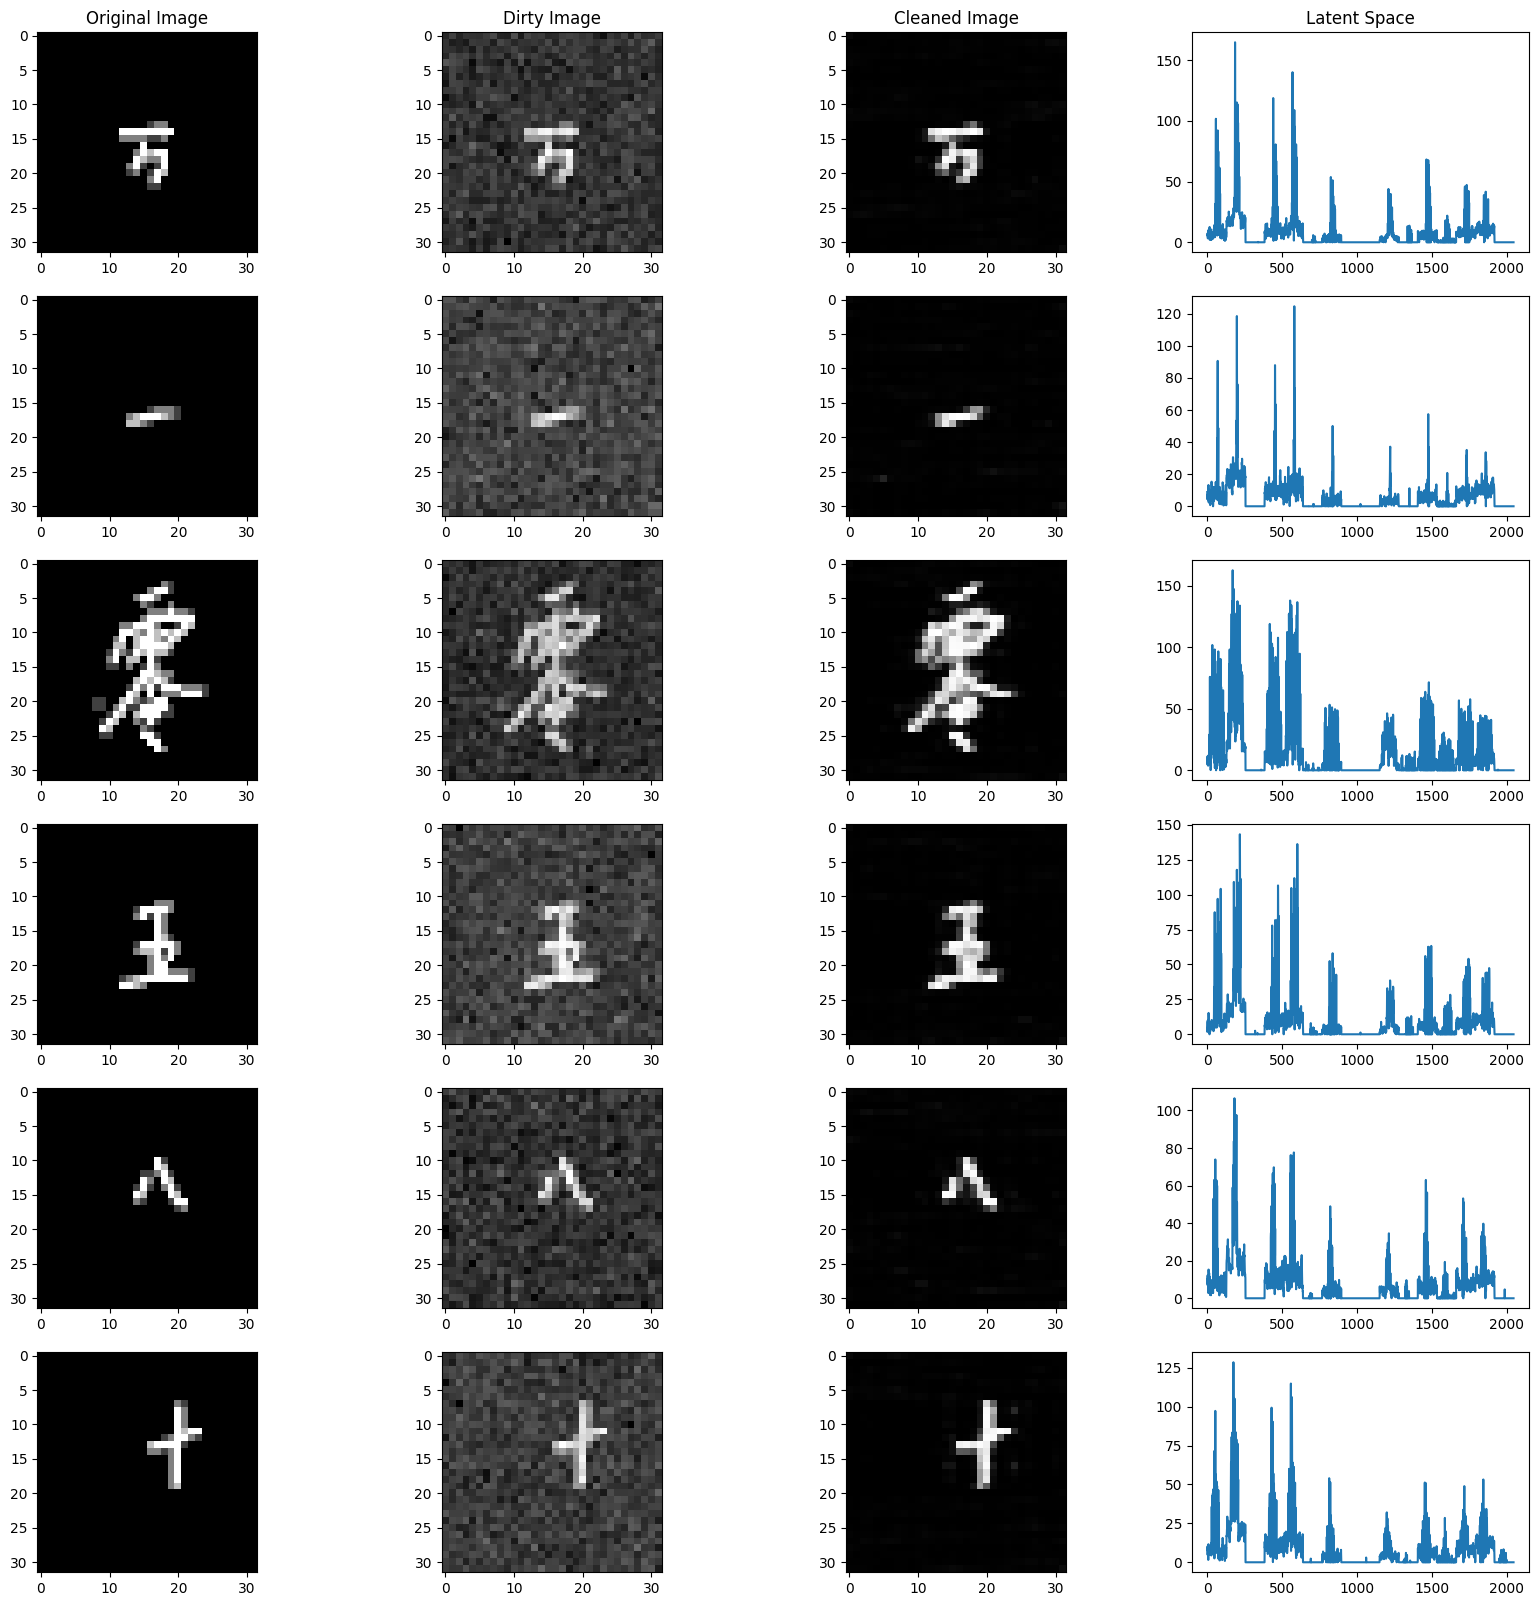

In [329]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 500, size=6)
i = 0
for dirty, clean in tqdm(testloader):
    i+=1
    dirty = dirty.view(dirty.size(0), 1, 32*32).type(torch.FloatTensor)
    print(dirty.shape)
    dirty = dirty.to(device)
    output = model(dirty)
    output_encoder = model.encoderConv1D(dirty)

    output = output.detach().cpu().numpy()
    output = output.reshape(32,32)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(32,32)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(32,32)

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[i-1, 0].imshow(clean, cmap="gray")
    axes[i-1, 1].imshow(dirty, cmap="gray")
    axes[i-1, 2].imshow(output, cmap="gray")
    axes[i-1, 3].plot(latent)

    if i == 6:
        break

plt.show()

In [330]:
SNRListe = []
PSNRListe = []

for dirty, clean in tqdm(testloader):

    dirty = dirty.view(1, 32*32).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.detach().cpu().numpy()
    output = output.reshape(32,32)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(32,32)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(32,32)


    PSNRListe.append(np.mean((output-clean)**2))

print(f"Moyenne SNR image bruitée : {np.mean(PSNRListe)}")

100%|██████████| 956/956 [00:01<00:00, 537.47it/s]

Moyenne SNR image bruitée : 0.0029542127158492804


In [372]:
PATH = "presentation/sinogrammeConv1D_10000.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH